<a href="https://colab.research.google.com/github/RyanG123ism/MLDA_Coursework_2/blob/main/MLDA_Coursework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MLDA - Coursework - League of Legends Data Set**

**Data Set Description:** League of Legends competitive matches between 2015-2017. The matches include the NALCS, EULCS, LCK, LMS, and CBLoL leagues as well as the World Championship and Mid-Season Invitational tournaments.

This data analysis will make use of the dataset above to perform deep learning techniques to help predict a teams chance of victory based on their champion selection

#Required Imports

In [1]:
#required imports
import kagglehub
import pandas as pd
import os

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Reading the Data

First the Dataset must be pulled from the corresponding kaggle directory and parsed for the correct 'LeagueofLegends' cvs file.

In [2]:
#Download latest version
path = kagglehub.dataset_download("chuckephron/leagueoflegends")


#find the appropriate csv file in directory
for filename in os.listdir(path):
    if filename == "LeagueofLegends.csv":
        csv_file_path = os.path.join(path, filename)
        break #stop after file is found

#setting the layout options for the output of the dataframe so that the data is more readable.
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

#reading file into dataframe
df = pd.read_csv(csv_file_path)

#Understanding the Data

Printing some generic data regarding the dataset to further increase our understanding of the data. Most of the columns are of 'Object' type, which means not much can be said about the type of data upon first glance and through simple techniques such as '.describe'

In [3]:
#The shape of the dataset
print("")
print("-------------------------SHAPE--------------------------")
print(df.shape)
print("")
print("--------------------------HEAD-------------------------")
#Listing the first 5 rows within the dataset
print(df.head())
print("")
print("--------------------------INFO-------------------------")
#information about the dataset
print(df.info())
print("")
print("-------------------------DESCRIBE------------------------")
#general statistics on the integer type columns
print(df.describe())


-------------------------SHAPE--------------------------
(7620, 57)

--------------------------HEAD-------------------------
  League  Year  Season    Type blueTeamTag  bResult  rResult redTeamTag  gamelength                                           golddiff                                           goldblue  \
0  NALCS  2015  Spring  Season         TSM        1        0         C9          40  [0, 0, -14, -65, -268, -431, -488, -789, -494,...  [2415, 2415, 2711, 3887, 5068, 6171, 7412, 866...   
1  NALCS  2015  Spring  Season         CST        0        1        DIG          38  [0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...  [2415, 2415, 2705, 4108, 5511, 6797, 7637, 895...   
2  NALCS  2015  Spring  Season         WFX        1        0         GV          40  [0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...  [2415, 2415, 2726, 3794, 4933, 6236, 8109, 965...   
3  NALCS  2015  Spring  Season         TIP        0        1         TL          41  [0, 0, -15, 25, 228, -6, -243, 17

#Cleaning the Data

##Selecting Significant Columns and Removing The Rest

In order to keep things as simple as possible, All uneccesary columns are removed from the dataset. This is to remove any clutter from the dataset as it is so large.

Since the rResult and bResult are of binary classification and a '1' in one column means a '0' in the other, we can remove the 'rResult' and assume that a '0' in 'bResult' means a win for the red team.

All columns relating to champion selection remain in the dataset.

In [4]:
#listing the columns relative to this study
columns_to_keep = [
    'bResult', 'blueTopChamp', 'blueMiddleChamp', 'blueJungleChamp',
    'blueADCChamp', 'blueSupportChamp', 'redTopChamp', 'redMiddleChamp',
    'redJungleChamp', 'redADCChamp', 'redSupportChamp'
]

#dropping all unrelated collumns
df_champions = df.loc[:, columns_to_keep]

#reviewing the chnage in shape
df_champions.head()

,bResult,blueTopChamp,blueMiddleChamp,blueJungleChamp,blueADCChamp,blueSupportChamp,redTopChamp,redMiddleChamp,redJungleChamp,redADCChamp,redSupportChamp
0,1,Irelia,Ahri,RekSai,Jinx,Janna,Gnar,Fizz,Elise,Sivir,Thresh
1,0,Gnar,Ahri,Rengar,Caitlyn,Leona,Irelia,Azir,JarvanIV,Corki,Annie
2,1,Renekton,Fizz,Rengar,Sivir,Annie,Sion,Azir,LeeSin,Corki,Janna
3,0,Irelia,Leblanc,JarvanIV,Sivir,Thresh,Gnar,Lulu,Nunu,KogMaw,Janna
4,1,Gnar,Lissandra,JarvanIV,Tristana,Janna,Sion,Lulu,RekSai,Corki,Annie


##Checking for Null Values and Duplicates

The dataset has no null values or corrupted data replaced with a '?' therefore we dont need to remove anything.

There are 2 duplicate columns. However, due to the nature of champion selection and the number of game instances, it is entirely possible that identical team layouts can occurr and share the same result, so they will not be removed from this dataset.  

In [5]:
#check for null values
null_values = df_champions.isnull()

#checking null values
if null_values.any().any():
    #if null values exist
    print("Null values are present in the DataFrame:")
    print(null_values)
else:
    print("No null values are present in the DataFrame.")

#check for '?' values
question_mark_values = df_champions.eq('?')

if question_mark_values.any().any():
    print("'?' values are present in the DataFrame:")
    print(question_mark_values)
else:
    print("No '?' values are present in the DataFrame.")

#check for duplicate values
duplicate_values = df_champions[df_champions.duplicated()]

#if there are duplicate values
if not duplicate_values.empty:
    print("Duplicate values are present in the DataFrame:")
    print(duplicate_values)
else:
    print("No duplicate values are present in the DataFrame.")

No null values are present in the DataFrame.
No '?' values are present in the DataFrame.
Duplicate values are present in the DataFrame:
      bResult blueTopChamp blueMiddleChamp blueJungleChamp blueADCChamp blueSupportChamp redTopChamp redMiddleChamp redJungleChamp redADCChamp redSupportChamp
1645        0       Maokai            Ryze         Kindred      Kalista           Thresh        Ekko           Azir         Graves      Ezreal         Trundle
6765        0        Poppy            Ekko         Nidalee       Lucian           Soraka     Trundle           Azir          Elise      Ezreal            Nami


#Visualising Champion Info

Visualising the champion count of each role. As the data shows, some champions are played much more frequently than others. This could be due to chance or popularity, or perhaps there is a reason?  Maybe some champions are better than others and lead to more wins?

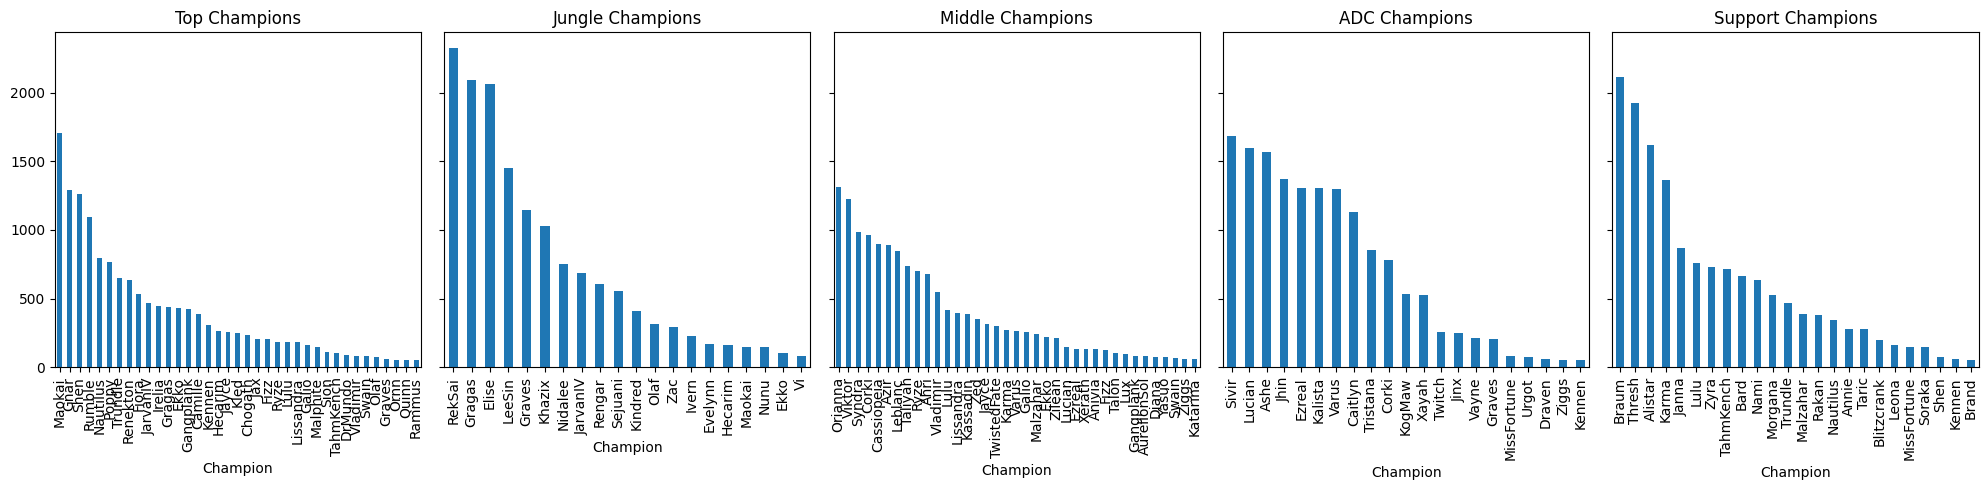

In [6]:

#Selecting columns to visualise together
topChampions = df_champions[['blueTopChamp', 'redTopChamp']]
jglChampions = df_champions[['blueJungleChamp', 'redJungleChamp']]
midChampions = df_champions[['blueMiddleChamp', 'redMiddleChamp']]
adcChampions = df_champions[['blueADCChamp', 'redADCChamp']]
suppChampions = df_champions[['blueSupportChamp', 'redSupportChamp']]

#TOP
#flattens the df into one column 'Champion'
topChampions_flat = topChampions.melt(value_name='Champion')['Champion']
filteredTopChamps = topChampions_flat.value_counts()[topChampions_flat.value_counts() > 50]

#JUNGLE
jglChampions_flat = jglChampions.melt(value_name='Champion')['Champion']
filteredjglChamps = jglChampions_flat.value_counts()[jglChampions_flat.value_counts() > 50]

#MIDDLE
midChampions_flat = midChampions.melt(value_name='Champion')['Champion']
filteredmidChamps = midChampions_flat.value_counts()[midChampions_flat.value_counts() > 50]

#ADC
adcChampions_flat = adcChampions.melt(value_name='Champion')['Champion']
filteredadcChamps = adcChampions_flat.value_counts()[adcChampions_flat.value_counts() > 50]

#SUPPORT
suppChampions_flat = suppChampions.melt(value_name='Champion')['Champion']
filteredsuppChamps = suppChampions_flat.value_counts()[suppChampions_flat.value_counts() > 50]

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Plot each role's data on its respective subplot
filteredTopChamps.plot(kind='bar', ax=axes[0], title='Top Champions')
filteredjglChamps.plot(kind='bar', ax=axes[1], title='Jungle Champions')
filteredmidChamps.plot(kind='bar', ax=axes[2], title='Middle Champions')
filteredadcChamps.plot(kind='bar', ax=axes[3], title='ADC Champions')
filteredsuppChamps.plot(kind='bar', ax=axes[4], title='Support Champions')

# Adjust layout for better appearance
fig.tight_layout()

# Show the plots
plt.show()




#Embedding Champions with Label



In order to see which champions or groups of champions are most likely to result in a teams victory, they need to be labelled with an Integer ID, so that they can be fed into a model and compared.

Each unique champion listed in the dataset is given an ID of integer type.

##Getting all Unique Champions from all 10 columns

In [7]:
#dropping Target Column so it doesnt get included in function below
df_champions.drop(columns=['bResult'], inplace=True)

#flatten all columns into a single list of UNIQUE champions
all_champions = pd.unique(df_champions.values.ravel())

print("All Unique Champions: ", all_champions)

All Unique Champions:  ['Irelia' 'Ahri' 'RekSai' 'Jinx' 'Janna' 'Gnar' 'Fizz' 'Elise' 'Sivir'
 'Thresh' 'Rengar' 'Caitlyn' 'Leona' 'Azir' 'JarvanIV' 'Corki' 'Annie'
 'Renekton' 'Sion' 'LeeSin' 'Leblanc' 'Lulu' 'Nunu' 'KogMaw' 'Lissandra'
 'Tristana' 'Kassadin' 'Xerath' 'Nami' 'Rumble' 'Blitzcrank' 'Orianna'
 'Zed' 'Vi' 'Morgana' 'Nocturne' 'Graves' 'Ezreal' 'Jax' 'Kalista'
 'Cassiopeia' 'Maokai' 'Malphite' 'Vayne' 'Nidalee' 'Lucian' 'Alistar'
 'Yasuo' 'Draven' 'Braum' 'Swain' 'Veigar' 'DrMundo' 'Syndra' 'Kennen'
 'Hecarim' 'Viktor' 'Gragas' 'FiddleSticks' 'Sejuani' 'Karthus' 'Chogath'
 'Nautilus' 'Urgot' 'Zac' 'Vladimir' 'Twitch' 'Katarina' 'Varus' 'Diana'
 'Ashe' 'Ziggs' 'Evelynn' 'Ryze' 'TwistedFate' 'Bard' 'Ekko' 'Karma'
 'XinZhao' 'Jayce' 'Shen' 'Olaf' 'Shyvana' 'MasterYi' 'Khazix' 'Riven'
 'Gangplank' 'Soraka' 'Amumu' 'Velkoz' 'MissFortune' 'Anivia' 'Kindred'
 'Fiora' 'Trundle' 'Poppy' 'TahmKench' 'Lux' 'Zilean' 'Quinn' 'Jhin'
 'Pantheon' 'Kayle' 'Udyr' 'Rammus' 'Zyra' 'Illaoi' 'B

In [8]:
#Create a mapping from champion names to integer IDs
champion_to_id = {champ: idx for idx, champ in enumerate(all_champions)}

#Create reverse mapping so that it can be referenced in the future
id_to_champion = {idx: champ for champ, idx in champion_to_id.items()}

#replace all champs with their ID in the dataset
df_champs_encoded = df_champions.replace(champion_to_id)

#adding bResult back into dataset
df_champs_encoded.insert(0, 'bResult', df['bResult'])

#displaying results
print("CHAMPIONS TO ID:")
print(champion_to_id)
print("-----------")
print("ID TO CHAMPIONS:")
print(id_to_champion) #
print("-----------")


CHAMPIONS TO ID:
{'Irelia': 0, 'Ahri': 1, 'RekSai': 2, 'Jinx': 3, 'Janna': 4, 'Gnar': 5, 'Fizz': 6, 'Elise': 7, 'Sivir': 8, 'Thresh': 9, 'Rengar': 10, 'Caitlyn': 11, 'Leona': 12, 'Azir': 13, 'JarvanIV': 14, 'Corki': 15, 'Annie': 16, 'Renekton': 17, 'Sion': 18, 'LeeSin': 19, 'Leblanc': 20, 'Lulu': 21, 'Nunu': 22, 'KogMaw': 23, 'Lissandra': 24, 'Tristana': 25, 'Kassadin': 26, 'Xerath': 27, 'Nami': 28, 'Rumble': 29, 'Blitzcrank': 30, 'Orianna': 31, 'Zed': 32, 'Vi': 33, 'Morgana': 34, 'Nocturne': 35, 'Graves': 36, 'Ezreal': 37, 'Jax': 38, 'Kalista': 39, 'Cassiopeia': 40, 'Maokai': 41, 'Malphite': 42, 'Vayne': 43, 'Nidalee': 44, 'Lucian': 45, 'Alistar': 46, 'Yasuo': 47, 'Draven': 48, 'Braum': 49, 'Swain': 50, 'Veigar': 51, 'DrMundo': 52, 'Syndra': 53, 'Kennen': 54, 'Hecarim': 55, 'Viktor': 56, 'Gragas': 57, 'FiddleSticks': 58, 'Sejuani': 59, 'Karthus': 60, 'Chogath': 61, 'Nautilus': 62, 'Urgot': 63, 'Zac': 64, 'Vladimir': 65, 'Twitch': 66, 'Katarina': 67, 'Varus': 68, 'Diana': 69, 'Ashe': 7

<ipython-input-8-e80a5561dac8>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_champs_encoded = df_champions.replace(champion_to_id)


#Creating Champion Team Representation


Now that all champions have been parsed into data which can easily work with a machine learning model, the data must be concatenated into a list of champions within a team and used to create an embedding matrix with a vector for all champions.  


## Create and Fill Team columns

In [9]:
#inserting new columns for red and blue team representation
df_champs_encoded.insert(11, 'bTeamRepresentation', value=None)
df_champs_encoded.insert(12, 'rTeamRepresentation', value=None)

#concatenating all blue and red champion ID's into their respective teams column
df_champs_encoded['bTeamRepresentation'] = df_champs_encoded[['blueTopChamp', 'blueMiddleChamp', 'blueJungleChamp', 'blueADCChamp', 'blueSupportChamp']].values.tolist()
df_champs_encoded['rTeamRepresentation'] = df_champs_encoded[['redTopChamp', 'redMiddleChamp', 'redJungleChamp', 'redADCChamp', 'redSupportChamp']].values.tolist()

#displaying new columns
print(df_champs_encoded.head(1))

   bResult  blueTopChamp  blueMiddleChamp  blueJungleChamp  blueADCChamp  blueSupportChamp  redTopChamp  redMiddleChamp  redJungleChamp  redADCChamp  redSupportChamp bTeamRepresentation  \
0        1             0                1                2             3                 4            5               6               7            8                9     [0, 1, 2, 3, 4]   

  rTeamRepresentation  
0     [5, 6, 7, 8, 9]  


#Create and Aggregate Embeddings

Now that we have an aggregate column of all champion ID's within a team, an embedding layer will be created to represent each categorical data type for a champion as a vector that can be computed and compared by a model. The previous map 'champion_to_id' will be used an as input for the embedding layer.

Further to this, embeddings for each team will be created to add a unique vector for collections of champions. This is to help the computer understand the synergies between certain champions and fruther comprehend the relationships of individual champions within a team.  

In [10]:
#creating the embedding layer - 140 champions and a vector dimension of 16
embedding_layer = Embedding(input_dim=140, output_dim=16) #Shape: (139 rows (per champion), 16 columnns (Vector Dimension/'richeness'))

# Define Input layers
bTeam_input = Input(shape=(5,), dtype=tf.int32, name="bTeam_input")  # Shape for blue team input
rTeam_input = Input(shape=(5,), dtype=tf.int32, name="rTeam_input")  # Shape for red team input

#passing TeamRepresentations through an embedding layer - game length is integer so dont need to do this for that column
bTeam_embeddings = embedding_layer(bTeam_input)
rTeam_embeddings = embedding_layer(rTeam_input)

#aggregating blue team embedding using mean pool average
blue_team_representation = Lambda(lambda x: K.mean(x, axis=1))(bTeam_embeddings)

#aggregating red team embedding using mean pool average
red_team_representation = Lambda(lambda x: K.mean(x, axis=1))(rTeam_embeddings)

#combine team respresentations
#joining vectors of each team into a 32 dimensional vector
combined_representation = Concatenate()([blue_team_representation, red_team_representation])  #Shape (batchsize, 32 (because 16*2))

#Create 3 'Dense' Layers of neural networks


3 layers which filter the representaiton down into a smaller and smaller vector and finally calculate the probalitly betwen 0-1 for a binary classification result

In [11]:
# Dense layers
x = Dense(64, activation='relu')(combined_representation)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

#Create the Model

What the Model Does Overall

Input:

Takes raw champion IDs for both teams.

Embedding:

Maps each champion ID to a dense vector representation (embedding).

Aggregation:

Combines the embeddings of all champions on each team into a single vector representing the team.

Combination:

Concatenates the blue and red team representations into one vector.

Dense Layers:

Passes the combined representation through a series of dense layers to learn interactions and predict the outcome.

Output:

Predicts the probability of the blue team winning the match.

In [12]:
# Define the model
model = Model(inputs=[bTeam_input, rTeam_input], outputs=output)

#creating optimiser to fit into model
optimser = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimser, loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bTeam_input (InputLayer)  │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rTeam_input (InputLayer)  │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 5, 16)          │          2,240 │ bTeam_input[0][0],     │
│                           │                        │                │ rTeam_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 16)             │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 16)             │              0 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32)             │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          2,112 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,465 (25.25 KB)

 Trainable params: 6,465 (25.25 KB)

 Non-trainable params: 0 (0.00 B)

#Training the Model

##Test Train Split

In [13]:
#team data
B = df_champs_encoded['bTeamRepresentation'].to_numpy()
R = df_champs_encoded['rTeamRepresentation'].to_numpy()

#results data
Y = df_champs_encoded['bResult'].to_numpy()

#Splitting the wine data into training and testing sets (80% train, 20% test) - adding a random state value incase we want to reproduce the test
b_train, b_test, r_train, r_test, y_train, y_test = train_test_split(B, R, Y, test_size=0.2, random_state=0)

print("Training blue team data:", len(b_train))
print("Testing blue team data:", len(b_test))
print("--------------------------------------")
print("Training red team data:", len(r_train))
print("Testing red team data:", len(r_test))
print("--------------------------------------")
print("Training results data:", len(y_train))
print("Testing results data:", len(y_test))

Training blue team data: 6096
Testing blue team data: 1524
--------------------------------------
Training red team data: 6096
Testing red team data: 1524
--------------------------------------
Training results data: 6096
Testing results data: 1524


##Fitting Data into The Model

In [14]:
model.fit(
    [tf.constant(b_train.tolist()), tf.constant(r_train.tolist())],  #Inputs
    tf.constant(y_train.tolist()),  #Labels
    epochs=5,
    batch_size=32
)


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5476 - loss: 0.6906
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5520 - loss: 0.6849
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5797 - loss: 0.6778
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5766 - loss: 0.6698
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5980 - loss: 0.6625


#Test The Model

In [15]:
# Evaluate the model
b_test, r_test, y_test = tf.constant(b_test.tolist()), tf.constant(r_test.tolist()), tf.constant(y_test.tolist())

test_loss, test_accuracy = model.evaluate([b_test, r_test], y_test, batch_size=32)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

#accuracy: 0.5356 - loss: 0.6897 epochs 5 adam ""
#accuracy: 0.5714 - loss: 0.6786 epochs 5 adam
#accuracy: 0.5667 - loss: 0.6827 - epochs 5 adam 0.01
#accuracy: 0.5194 - loss: 0.7116 - epochs 10 adam 0.01
#accuracy: 0.5502 - loss: 0.6895 - epochs 5 adam 0.015
#accuracy: 0.5671 - loss: 0.6985 - epochs 5 adam 0.01
#accuracy: 0.5695 - loss: 0.6839 - epoch 5 adamW 0.001 weight decay 1e-5
#accuracy: 0.5252 - loss: 0.6974 - epoch 5 adamW 0.001 weight decay 1e-6
#accuracy: 0.5657 - loss: 0.6796 - epoch 5 adamW 0.001 weight decay 1e-4
#accuracy: 0.5647 - loss: 0.6829 - epochs 5 adam 0.01 batch decrease to 16

#BEST SO FAR
#accuracy: 0.5878 - loss: 0.6921 - epochs 5, adam 0.01 batch size 32


#improving the models accuracy - keeping epochs between 5-10 to not overfit
#increased learning rate from 0.001 to 0.01


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5647 - loss: 0.6850
Test Loss: 0.6871154308319092, Test Accuracy: 0.5682414770126343
